<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Conexión de OpenScale con Watson Machine Learning

Este notebook debe ejecutarse en un proyecto de Watson Studio, utilizando el entorno de tiempo de ejecución ** Python 3.6 ** predeterminado. Requiere credenciales de servicio para los siguientes servicios en la nube:

  * Watson OpenScale
  * Watson Machine Learning

Este notebook capacitará, creará e implementará un modelo de riesgo de crédito alemán, configurará OpenScale para monitorear esa implementación e inyectará registros y mediciones históricas durante siete días para ver en el panel de instrumentos de OpenScale Insights.

### Contenido

- [Instalación](#setup)
- [Construcción del modelo y despliegue](#model)
- [Configuración de OpenScale](#openscale)
- [Monitor de calidad y registro de logs](#quality)
- [Monitorización del fairness y explicabilidad](#fairness)
- [Monitorización del Drift](#drift)
- [Métricas personalizadas](#custom)
- [Analítica](#analytics)
- [Aplicaciones de negocio](#application)
- [Datos históricos](#historical)
- [Ejecuta aplicaciones de negocio](#run_application)

# -----------------------**PRIMERA SECCIÓN**-----------------------------------------

# 1. Instalación <a name="setup"></a>

## 1.1. Instalación de los paquetes

In [1]:
!pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1
!pip install lime --no-cache | tail -n 1

## 1.2. Aprovisionamiento de los servicios y configuración de las credenciales

Si aún no la tienes aprovisiona una instancia de Watson OpenScale [Acceso a Watson OpenScale en el Catálogo de IBM ](https://cloud.ibm.com/catalog/services/watson-openscale).

Necesitáis generar un Cloud API KEY. Podéis hacerlo yendo a [La sección de **Ususarios** de la consola Cloud](https://cloud.ibm.com/iam#/users). Desde esa página, haz click en tu nombre, haz scroll hasta la sección de **API Keys** , y haz click en **Crear un IBM Cloud API key**. Proporciona un nombre a la key y haz click en **Crear**, después cópiala y pégala más abajo.

**NOTA:** También puedes obtener la `API_KEY` usando la IBM CLOUD CLI.

Cómo instalar la CLI de IBM Cloud : [instrucciones](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

¿Cómo obtener la API Key desde la consola:
```
bx login --sso
bx iam api-key-create 'my_key'
```

In [2]:
CLOUD_API_KEY = "PASTE HERE"

A continuación, necesitarás credenciales para Watson Machine Learning. Si ya tienes una instancia WML, puedes usar credenciales para ella. 
Para aprovisionar una nueva instancia Lite de WML, use el [Catálogo de la nube] (https://cloud.ibm.com/catalog/services/machine-learning), asigne un nombre a su servicio y haga clic en **Crear**. Una vez que se crea su instancia, haga clic en el enlace **Credenciales de servicio** en el lado izquierdo de la pantalla. Haga clic en el botón **Nueva credencial**, asigne un nombre a sus credenciales y haga clic en **Agregar**. Puede acceder a sus nuevas credenciales haciendo clic en el botón **Ver credenciales**. Copiad y pegad sus credenciales WML en la celda a continuación.

In [2]:
WML_CREDENTIALS = {
    "apikey": "key",
    "iam_apikey_description": "description",
    "iam_apikey_name": "auto-generated-apikey",
    "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
    "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::",
    "instance_id": "instance_id",
    "password": "password",
    "url": "https://us-south.ml.cloud.ibm.com",
    "username": "username"
}

Este tutorial usa la versión gratuita interna de PostgreSQL para crear un datamart para OpenScale.

In [3]:
DB_CREDENTIALS = None

In [8]:
KEEP_MY_INTERNAL_POSTGRES = True

## 1.3. Ejecuta el notebook

En este punto, el notebook está lista para ejecutarse. Puede ejecutar las celdas una a la vez o hacer clic en la opción **Kernel** anterior y seleccionar **Reiniciar y ejecutar todo** para ejecutar todas las celdas.

# 2. Construcción del modelo y despliegue <a name="model"></a>

En esta sección aprenderás cómo entrenar el modelo Scikit-learn y luego implementarlo como servicio web utilizando el servicio Watson Machine Learning.

## 2.1. Cargando los datos desde github

In [4]:
!rm german_credit_data_biased_training.csv
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv

rm: cannot remove ‘german_credit_data_biased_training.csv’: No such file or directory
--2020-04-01 09:43:01--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689622 (673K) [text/plain]
Saving to: ‘german_credit_data_biased_training.csv’

100%[======================================>] 689,622     --.-K/s   in 0.03s   

2020-04-01 09:43:02 (21.2 MB/s) - ‘german_credit_data_biased_training.csv’ saved [689622/689622]



In [5]:
import numpy as np
import pandas as pd

data_df = pd.read_csv('german_credit_data_biased_training.csv')

## 2.2. Exploración de los datos

In [11]:
data_df.head()

CheckingStatus  LoanDuration           CreditHistory LoanPurpose  \
0       0_to_200            31    credits_paid_to_date       other   
1         less_0            18    credits_paid_to_date     car_new   
2         less_0            15  prior_payments_delayed   furniture   
3       0_to_200            28    credits_paid_to_date  retraining   
4    no_checking            28  prior_payments_delayed   education   

   LoanAmount ExistingSavings EmploymentDuration  InstallmentPercent     Sex  \
0        1889      100_to_500             less_1                   3  female   
1         462        less_100             1_to_4                   2  female   
2         250        less_100             1_to_4                   2    male   
3        3693        less_100          greater_7                   3    male   
4        6235     500_to_1000          greater_7                   3    male   

  OthersOnLoan  ...       OwnsProperty Age  InstallmentPlans Housing  \
0         none  ...  savings_insurance  32              none     own   
1         none  ...  savings_insurance  37            stores     own   
2         none  ...        real_estate  28              none     own   
3         none  ...  savings_insurance  32              none     own   
4         none  ...            unknown  57              none     own   

  ExistingCreditsCount      Job Dependents  Telephone ForeignWorker     Risk  
0                    1  skilled          1       none           yes  No Risk  
1                    2  skilled          1       none           yes  No Risk  
2                    2  skilled          1        yes            no  No Risk  
3                    1  skilled          1       none           yes  No Risk  
4                    2  skilled          1       none           yes     Risk  

[5 rows x 21 columns]

In [9]:
print('Columnas: ', list(data_df.columns))
print('Número de columnas: ', len(data_df.columns))

Columnas:  ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker', 'Risk']
Número de columnas:  21


Como puedes ver, los datos contienen 21 campos. El campo `Riesgo` es el que nos gustaría predecir (TARGET) utilizando los datos de feedback.

In [10]:
print('Número de registros: ', data_df.Risk.count())

Número de registros:  5000


In [11]:
target_count = data_df.groupby('Risk')['Risk'].count()
target_count

Risk
No Risk    3330
Risk       1670
Name: Risk, dtype: int64

## 2.3. Creación del modelo

En esta sección vamos a llevar a cabo los siguientes pasos:

- Preparar datos para entrenar el modelo
- Creación de la pipeline de machine learning
- Entrenamiento del modelo

In [16]:
MODEL_NAME = "Scikit German Risk Model"
DEPLOYMENT_NAME = "Scikit German Risk Deployment"

### Importamos las librerías necesarias

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

### Dividimos el dataset en entrenamiento y test

In [18]:
train_data, test_data = train_test_split(data_df, test_size=0.2)

### Preparamos la pipeline

In [19]:
features_idx = np.s_[0:-1]
all_records_idx = np.s_[:]
first_record_idx = np.s_[0]

En este paso codificará las etiquetas de las columnas de destino en valores numéricos. Puede usar `inverse_transform` para decodificar predicciones numéricas en etiquetas.

In [20]:
string_fields = [type(fld) is str for fld in train_data.iloc[first_record_idx, features_idx]]
ct = ColumnTransformer([("ohe", OneHotEncoder(), list(np.array(train_data.columns)[features_idx][string_fields]))])
clf_linear = SGDClassifier(loss='log', penalty='l2', max_iter=1000, tol=1e-5)

pipeline_linear = Pipeline([('ct', ct), ('clf_linear', clf_linear)])

### Entrenamos al modelo

In [21]:
risk_model = pipeline_linear.fit(train_data.drop('Risk', axis=1), train_data.Risk)

### Evaluamos el modelo

In [22]:
from sklearn.metrics import roc_auc_score

predictions = risk_model.predict(test_data.drop('Risk', axis=1))
indexed_preds = [0 if prediction=='No Risk' else 1 for prediction in predictions]

real_observations = test_data.Risk.replace('Risk', 1)
real_observations = real_observations.replace('No Risk', 0).values

auc = roc_auc_score(real_observations, indexed_preds)
print(auc)

0.7480856491358466


## 2.4 Publicamos el modelo

En esta sección, el notebook utiliza las credenciales de Watson Machine Learning proporcionadas para guardar el modelo (incluida la pipeline) en la instancia de WML. Las versiones anteriores del modelo se eliminan para que el notebook se pueda volver a ejecutar, restableciendo todos los datos para otra demostración.

In [23]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import json

wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)

### Eliminamos el despliegue anterior si existe y persistimos el nuevo

In [23]:
model_deployment_ids = wml_client.deployments.get_uids()
for deployment_id in model_deployment_ids:
    deployment = wml_client.deployments.get_details(deployment_id)
    model_id = deployment['entity']['deployable_asset']['guid']
    if deployment['entity']['name'] == DEPLOYMENT_NAME:
        print('Deleting deployment id', deployment_id)
        wml_client.deployments.delete(deployment_id)
        print('Deleting model id', model_id)
        wml_client.repository.delete(model_id)
wml_client.repository.list_models()

NameError: name 'wml_client' is not defined

In [25]:
model_props = {
    wml_client.repository.ModelMetaNames.NAME: "{}".format(MODEL_NAME),
    wml_client.repository.ModelMetaNames.EVALUATION_METHOD: "binary",
    wml_client.repository.ModelMetaNames.EVALUATION_METRICS: [
        {
           "name": "areaUnderROC",
           "value": auc,
           "threshold": 0.7
        }
    ]
}

In [26]:
wml_models = wml_client.repository.get_details()
model_uid = None
for model_in in wml_models['models']['resources']:
    if MODEL_NAME == model_in['entity']['name']:
        model_uid = model_in['metadata']['guid']
        break

if model_uid is None:
    print("Storing model ...")

    published_model_details = wml_client.repository.store_model(model=risk_model, meta_props=model_props, training_data=data_df.drop(['Risk'], axis=1), training_target=data_df.Risk)
    model_uid = wml_client.repository.get_model_uid(published_model_details)
    print("Done")

Storing model ...
Done


In [27]:
model_uid

'4034d109-a06d-4919-8bd2-01658aea8792'

## 2.5. Desplegamos el modelo

La siguiente sección del notebook implementa el modelo como un servicio web RESTful en Watson Machine Learning. El modelo implementado tendrá una URL de puntuación que puede usar para enviar datos al modelo para predicciones.

In [29]:
wml_deployments = wml_client.deployments.get_details()
deployment_uid = None
for deployment in wml_deployments['resources']:
    if DEPLOYMENT_NAME == deployment['entity']['name']:
        deployment_uid = deployment['metadata']['guid']
        break

if deployment_uid is None:
    print("Deploying model...")

    deployment = wml_client.deployments.create(artifact_uid=model_uid, name=DEPLOYMENT_NAME, asynchronous=False)
    deployment_uid = wml_client.deployments.get_uid(deployment)
    
print("Model id: {}".format(model_uid))
print("Deployment id: {}".format(deployment_uid))

Deploying model...


#######################################################################################

Synchronous deployment creation for uid: '4034d109-a06d-4919-8bd2-01658aea8792' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='9c73141e-6197-4e29-ac94-794554f76477'
------------------------------------------------------------------------------------------------


Model id: 4034d109-a06d-4919-8bd2-01658aea8792
Deployment id: 9c73141e-6197-4e29-ac94-794554f76477


## 2.5. Scoring del  modelo

In [30]:
fields = ["CheckingStatus", "LoanDuration", "CreditHistory", "LoanPurpose", "LoanAmount", "ExistingSavings",
                  "EmploymentDuration", "InstallmentPercent", "Sex", "OthersOnLoan", "CurrentResidenceDuration",
                  "OwnsProperty", "Age", "InstallmentPlans", "Housing", "ExistingCreditsCount", "Job", "Dependents",
                  "Telephone", "ForeignWorker"]
values = [
            ["no_checking", 13, "credits_paid_to_date", "car_new", 1343, "100_to_500", "1_to_4", 2, "female", "none", 3,
             "savings_insurance", 46, "none", "own", 2, "skilled", 1, "none", "yes"],
            ["no_checking", 24, "prior_payments_delayed", "furniture", 4567, "500_to_1000", "1_to_4", 4, "male", "none",
             4, "savings_insurance", 36, "none", "free", 2, "management_self-employed", 1, "none", "yes"],
        ]

scoring_payload = {"fields": fields, "values": values}

In [31]:
scoring_url = wml_client.deployments.get_scoring_url(deployment)

wml_client.deployments.score(scoring_url, scoring_payload)

{'fields': ['prediction', 'probability'],
 'values': [['No Risk', [0.685076399597548, 0.31492360040245204]],
  ['No Risk', [0.8071615490213502, 0.19283845097864982]]]}

# 3. Configurar OpenScale <a name="openscale"></a>

Este notebook ahora importará las bibliotecas necesarias y configurará un cliente Python OpenScale.

In [24]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
from ibm_ai_openscale.supporting_classes.enums import *

### Obtén Watson OpenScale GUID

Cada instancia de OpenScale tiene un ID único. Podemos obtener este valor utilizando el Cloud API key que hemos específicado al inicio del notebook.

In [33]:
import requests
from ibm_ai_openscale.utils import get_instance_guid


WOS_GUID = get_instance_guid(api_key=CLOUD_API_KEY)
WOS_CREDENTIALS = {
    "instance_guid": WOS_GUID,
    "apikey": CLOUD_API_KEY,
    "url": "https://api.aiopenscale.cloud.ibm.com"
}

if WOS_GUID is None:
    print('Watson OpenScale GUID NOT FOUND')
else:
    print(WOS_GUID)

27d2155a-b202-44ac-955e-ee20b64f6c89


In [34]:
ai_client = APIClient(aios_credentials=WOS_CREDENTIALS)
ai_client.version

'2.1.21'

## 3.1. Creación del schema y datamart

### Configuración del datamart

Watson OpenScale utiliza una base de datos para almacenar registros de carga útil y métricas calculadas. Si las credenciales de la base de datos **no** se suministraron anteriormente, el notebook utilizará la base de datos interna gratuita 

Las instancias anteriores del modelo de crédito alemán se eliminarán de la supervisión de OpenScale.

In [35]:
try:
    data_mart_details = ai_client.data_mart.get_details()
    if 'internal_database' in data_mart_details and data_mart_details['internal_database']:
        if KEEP_MY_INTERNAL_POSTGRES:
            print('Using existing internal datamart.')
        else:
            if DB_CREDENTIALS is None:
                print('No postgres credentials supplied. Using existing internal datamart')
            else:
                print('Switching to external datamart')
                ai_client.data_mart.delete(force=True)
                ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS)
    else:
        print('Using existing external datamart')
except:
    if DB_CREDENTIALS is None:
        print('Setting up internal datamart')
        ai_client.data_mart.setup(internal_db=True)
    else:
        print('Setting up external datamart')
        try:
            ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS)
        except:
            print('Setup failed, trying Db2 setup')
            ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS, schema=DB_CREDENTIALS['username'])
    

Using existing external datamart


In [36]:
data_mart_details = ai_client.data_mart.get_details()

## 3.2. Configuración del engine de machine learning

Watson OpenScale debe estar vinculado a la instancia de Watson Machine Learning para capturar datos de carga útil dentro y fuera del modelo. Si este enlace ya existe, este código generará un mensaje de advertencia y usará el enlace existente.

In [37]:
binding_uid = ai_client.data_mart.bindings.add('WML instance', WatsonMachineLearningInstance(WML_CREDENTIALS))
if binding_uid is None:
    binding_uid = ai_client.data_mart.bindings.get_details()['service_bindings'][0]['metadata']['guid']
bindings_details = ai_client.data_mart.bindings.get_details()
ai_client.data_mart.bindings.list()

Warning during bind instance.
Status code: 409, body: {"errors":[{"code":"AIQCS0010W","message":"Service Binding with this id is already defined"}],"trace":"MmM0YTlkYjctYWMwYy00MjZhLTliOTAtNzVmMzU4YzlhMzZi"}


In [38]:
print(binding_uid)

e2cde82b-8a94-4d97-9d46-2288dd99c3af


In [39]:
ai_client.data_mart.bindings.list_assets()

## 3.3. Suscripciones

### Eliminar suscripciones existentes del modelo de riesgo

Este código elimina las suscripciones anteriores al modelo de crédito alemán para actualizar los monitores con el nuevo modelo y los nuevos datos

In [40]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
for subscription in subscriptions_uids:
    sub_name = ai_client.data_mart.subscriptions.get_details(subscription)['entity']['asset']['name']
    if sub_name == MODEL_NAME:
        ai_client.data_mart.subscriptions.delete(subscription)
        print('Deleted existing subscription for', MODEL_NAME)

Deleted existing subscription for Scikit German Risk Model


Este código crea la suscripción modelo en OpenScale usando la API del cliente Python. Tenga en cuenta que debemos proporcionar el identificador único del modelo y cierta información sobre el modelo en sí.

In [41]:
subscription = ai_client.data_mart.subscriptions.add(WatsonMachineLearningAsset(
    model_uid,
    problem_type=ProblemType.BINARY_CLASSIFICATION,
    input_data_type=InputDataType.STRUCTURED,
    label_column='Risk',
    transaction_id_column='transaction_id',
    prediction_column='prediction',
    probability_column='probability',
    feature_columns = ["CheckingStatus","LoanDuration","CreditHistory","LoanPurpose","LoanAmount","ExistingSavings","EmploymentDuration","InstallmentPercent","Sex","OthersOnLoan","CurrentResidenceDuration","OwnsProperty","Age","InstallmentPlans","Housing","ExistingCreditsCount","Job","Dependents","Telephone","ForeignWorker"],
    categorical_columns = ["CheckingStatus","CreditHistory","LoanPurpose","ExistingSavings","EmploymentDuration","Sex","OthersOnLoan","OwnsProperty","InstallmentPlans","Housing","Job","Telephone","ForeignWorker"],
    training_data_reference = {'connection': {'database_name': 'BLUDB',
                                              'hostname': 'dashdb-txn-sbox-yp-dal09-03.services.dal.bluemix.net',
                                              'password': 'khhz72v+6mcwwkfv',
                                              'username': 'cmb91569'},
                                             'location': {'schema_name': 'CMB91569',
                                              'table_name': 'CREDIT_RISK_TRAIN_DATA'},
                                             'type': 'db2'}
    
))

if subscription is None:
    print('Subscription already exists; get the existing one')
    subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
    for sub in subscriptions_uids:
        if ai_client.data_mart.subscriptions.get_details(sub)['entity']['asset']['name'] == MODEL_NAME:
            subscription = ai_client.data_mart.subscriptions.get(sub)

Obtener listas de suscripciones

In [42]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
ai_client.data_mart.subscriptions.list()

In [43]:
subscription_details = subscription.get_details()

### Haz el scoring del modelo para que podamos configurar monitores

Ahora que el servicio WML se ha vinculado y se ha creado la suscripción, debemos enviar una solicitud al modelo antes de configurar OpenScale. Esto permite a OpenScale crear un registro de carga útil en el datamart con el esquema correcto, para que pueda capturar los datos que entran y salen del modelo. Primero, el código obtiene la URL del punto final de implementación del modelo y luego envía algunos registros para las predicciones.

In [44]:
credit_risk_scoring_endpoint = None
print(deployment_uid)

for deployment in wml_client.deployments.get_details()['resources']:
    if deployment_uid in deployment['metadata']['guid']:
        credit_risk_scoring_endpoint = deployment['entity']['scoring_url']
        
print(credit_risk_scoring_endpoint)

9c73141e-6197-4e29-ac94-794554f76477
https://us-south.ml.cloud.ibm.com/v3/wml_instances/e2cde82b-8a94-4d97-9d46-2288dd99c3af/deployments/9c73141e-6197-4e29-ac94-794554f76477/online


In [45]:
fields = ["CheckingStatus","LoanDuration","CreditHistory","LoanPurpose","LoanAmount","ExistingSavings","EmploymentDuration","InstallmentPercent","Sex","OthersOnLoan","CurrentResidenceDuration","OwnsProperty","Age","InstallmentPlans","Housing","ExistingCreditsCount","Job","Dependents","Telephone","ForeignWorker"]
values = [
  ["no_checking",13,"credits_paid_to_date","car_new",1343,"100_to_500","1_to_4",2,"female","none",3,"savings_insurance",46,"none","own",2,"skilled",1,"none","yes"],
  ["no_checking",24,"prior_payments_delayed","furniture",4567,"500_to_1000","1_to_4",4,"male","none",4,"savings_insurance",36,"none","free",2,"management_self-employed",1,"none","yes"],
  ["0_to_200",26,"all_credits_paid_back","car_new",863,"less_100","less_1",2,"female","co-applicant",2,"real_estate",38,"none","own",1,"skilled",1,"none","yes"],
  ["0_to_200",14,"no_credits","car_new",2368,"less_100","1_to_4",3,"female","none",3,"real_estate",29,"none","own",1,"skilled",1,"none","yes"],
  ["0_to_200",4,"no_credits","car_new",250,"less_100","unemployed",2,"female","none",3,"real_estate",23,"none","rent",1,"management_self-employed",1,"none","yes"],
  ["no_checking",17,"credits_paid_to_date","car_new",832,"100_to_500","1_to_4",2,"male","none",2,"real_estate",42,"none","own",1,"skilled",1,"none","yes"],
  ["no_checking",33,"outstanding_credit","appliances",5696,"unknown","greater_7",4,"male","co-applicant",4,"unknown",54,"none","free",2,"skilled",1,"yes","yes"],
  ["0_to_200",13,"prior_payments_delayed","retraining",1375,"100_to_500","4_to_7",3,"male","none",3,"real_estate",37,"none","own",2,"management_self-employed",1,"none","yes"]
]

payload_scoring = {"fields": fields,"values": values}
scoring_response = wml_client.deployments.score(credit_risk_scoring_endpoint, payload_scoring)

print('Single record scoring result:', '\n fields:', scoring_response['fields'], '\n values: ', scoring_response['values'][0])

Single record scoring result: 
 fields: ['prediction', 'probability'] 
 values:  ['No Risk', [0.685076399597548, 0.31492360040245204]]


# -----------------------**SEGUNDA SECCIÓN**-----------------------------------------

# 4. Monitorización de la calidad y feedback <a name="quality"></a>

## 4.1. Habilitar la monitorización de la calidad


El siguiente código espera diez segundos para permitir que se configure la tabla de registro de carga antes de que comience a habilitar los monitores. Primero, enciende el monitor de calidad (precisión) y establece un umbral de alerta del 70%. OpenScale mostrará una alerta en el tablero si la medición de precisión del modelo (área debajo de la curva, en el caso de un clasificador binario) cae por debajo de este umbral.

El segundo parámetro suministrado, min_records, especifica el número mínimo de registros de retroalimentación que necesita OpenScale antes de calcular una nueva medición. El monitor de calidad se ejecuta cada hora, pero la lectura de precisión en el tablero no cambiará hasta que se hayan agregado 50 registros de comentarios adicionales, a través de la interfaz de usuario, el cliente de Python o el punto final de comentarios suministrado.

In [46]:
time.sleep(10)
subscription.quality_monitoring.enable(threshold=0.7, min_records=50)

## 4.2. Recogemos el feedback

El siguiente código descarga y almacena suficientes datos de feedback para alcanzar el umbral mínimo para que OpenScale pueda calcular una nueva medición de precisión. Luego inicia el monitor de precisión. Los monitores se ejecutan cada hora o se pueden iniciar a través de la API de Python, la API REST o la interfaz gráfica de usuario.

In [47]:
!rm additional_feedback_data.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/additional_feedback_data.json

--2020-01-31 13:20:49--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/additional_feedback_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16506 (16K) [text/plain]
Saving to: ‘additional_feedback_data.json’

100%[======================================>] 16,506      --.-K/s   in 0.002s  

2020-01-31 13:20:49 (9.16 MB/s) - ‘additional_feedback_data.json’ saved [16506/16506]



In [48]:
with open('additional_feedback_data.json') as feedback_file:
    additional_feedback_data = json.load(feedback_file)
    
subscription.feedback_logging.store(additional_feedback_data['data'])

In [49]:
subscription.feedback_logging.show_table()

In [50]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run 97da1ca3-0488-465a-af72-d53d5fb1e466 




completed

---------------------------
 Successfully finished run 
---------------------------




In [51]:
subscription.quality_monitoring.show_table()

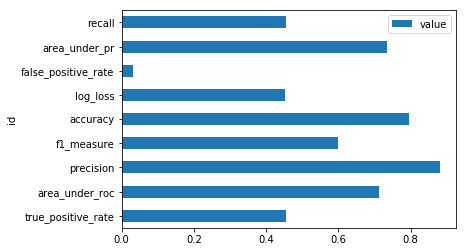

In [52]:
%matplotlib inline

quality_pd = subscription.quality_monitoring.get_table_content(format='pandas')
quality_pd.plot.barh(x='id', y='value');

# -----------------------**TERCERA SECCIÓN**-----------------------------------------

# 5. Monitorización de fairness y explicabilidad <a name="fairness"></a>

## 5.1. Configuración del Fairness

El siguiente código configura la monitorización de equidad para nuestro modelo. Activa la monitorización de dos funciones, Sexo y Edad. En cada caso, debemos especificar:
  * Qué característica del modelo monitorizar
  * Uno o más grupos **mayoritarios**, que son valores de esa característica que esperamos recibir un mayor porcentaje de resultados favorables
  * Uno o más grupos **minoritarios**, que son valores de esa característica que esperamos recibir un mayor porcentaje de resultados desfavorables
  * El umbral en el que nos gustaría que OpenScale muestre una alerta si la medición de equidad cae por debajo (en este caso, 95%)

Además, debemos especificar qué resultados del modelo son resultados favorables y cuáles son desfavorables. También debemos proporcionar el número de registros que OpenScale usará para calcular el puntaje de equidad. En este caso, el monitor de imparcialidad de OpenScale se ejecutará cada hora, pero no calculará una nueva calificación de imparcialidad hasta que se hayan agregado al menos 200 registros. Finalmente, para calcular la equidad, OpenScale debe realizar algunos cálculos sobre los datos de entrenamiento, por lo que proporcionamos el marco de datos que contiene los datos.

In [1]:
subscription.fairness_monitoring.enable(
            features=[
                Feature("Sex", majority=['male'], minority=['female'], threshold=0.95),
                Feature("Age", majority=[[26,75]], minority=[[18,25]], threshold=0.95)
            ],
            favourable_classes=['No Risk'],
            unfavourable_classes=['Risk'],
            min_records=200,
            training_data=train_data.copy()
        )

NameError: name 'subscription' is not defined

## 5.2. Configuración del Drift

In [54]:
subscription.drift_monitoring.enable(threshold=0.05, min_records=200)

{'config_status': {'model_name': None, 'state': 'new'},
 'data_drift_enabled': True,
 'drift_threshold': 0.05,
 'is_schedule_enabled': True,
 'min_samples': 200,
 'model_drift_enabled': True,
 'schedule_repeat_interval': 3,
 'schedule_repeat_type': 'hour'}

In [55]:
drift_status = None
while drift_status != 'finished':
    drift_details = subscription.drift_monitoring.get_details()
    drift_status = drift_details['parameters']['config_status']['state']
    if drift_status != 'finished':
        print(datetime.utcnow().strftime('%H:%M:%S'), drift_status)
        time.sleep(30)
print(drift_status)

13:21:08 new
13:21:38 in_progress
13:22:09 in_progress
13:22:39 in_progress
13:23:09 in_progress
finished


## 5.3. Evaluamos el modelo de nuevo ahora que los monitores están configurados

La siguiente sección selecciona aleatoriamente 200 registros de la fuente de datos y los envía al modelo para predicciones. Esto es suficiente para superar el umbral mínimo para los registros establecidos en la sección anterior, lo que permite que OpenScale comience a calcular la equidad.

In [58]:
from IPython.utils import io

with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_feed.json -O german_credit_feed.json
!ls -lh german_credit_feed.json

-rw-r----- 1 dsxuser dsxuser 3.0M Jan 31 13:25 german_credit_feed.json


Evalua 200 registros al azar

In [59]:
import random

with open('german_credit_feed.json', 'r') as scoring_file:
    scoring_data = json.load(scoring_file)

fields = scoring_data['fields']
values = []
for _ in range(200):
    values.append(random.choice(scoring_data['values']))
payload_scoring = {"fields": fields, "values": values}

scoring_response = wml_client.deployments.score(credit_risk_scoring_endpoint, payload_scoring)
time.sleep(5)

**Nota:** Ahora en el payload debe haber un total de 208 registros.

In [60]:
print('Number of records in payload table: ', subscription.payload_logging.get_records_count())

Number of records in payload table:  208


## 5.4. Ejecutar monitor de fairness

Monitorizamos el fairness. El monitor se ejecuta cada hora, pero se puede iniciar manualmente utilizando el cliente Python, la API REST o la interfaz gráfica de usuario.

In [61]:
run_details = subscription.fairness_monitoring.run(background_mode=False)




 Counting bias for deployment_uid=9c73141e-6197-4e29-ac94-794554f76477 




RUNNING....
FINISHED

---------------------------
 Successfully finished run 
---------------------------




In [62]:
time.sleep(10)

subscription.fairness_monitoring.show_table()

## 5.5. Ejecutar monitor del drift


Inicia el monitor de drift. El monitor se ejecuta cada hora, pero puede ser inicilizado manualmente con el cliente de Python o la API REST. 

In [63]:
drift_run_details = subscription.drift_monitoring.run(background_mode=False)




 Waiting for end of drift monitoring run  




COMPLETED

---------------------------
 Successfully finished run 
---------------------------




In [64]:
time.sleep(5)

subscription.drift_monitoring.get_table_content()

ts                    id  \
0 2020-01-31 13:26:08.594264+00:00  data_drift_magnitude   
1 2020-01-31 13:26:08.594264+00:00       drift_magnitude   
2 2020-01-31 13:26:08.594264+00:00    predicted_accuracy   
3 2020-01-31 13:25:27.805258+00:00  data_drift_magnitude   
4 2020-01-31 13:25:27.805258+00:00       drift_magnitude   
5 2020-01-31 13:25:27.805258+00:00    predicted_accuracy   

                         measurement_id     value lower limit upper limit  \
0  2c116876-dfa7-4b73-aa0a-4468c5b37a46  0.086538                           
1  2c116876-dfa7-4b73-aa0a-4468c5b37a46  0.022269                    0.05   
2  2c116876-dfa7-4b73-aa0a-4468c5b37a46  0.772731                           
3  0ceb7722-614e-4a3d-aaf7-04335ee2a877  0.086538                           
4  0ceb7722-614e-4a3d-aaf7-04335ee2a877  0.022269                    0.05   
5  0ceb7722-614e-4a3d-aaf7-04335ee2a877  0.772731                           

  tags                            binding_id  \
0       e2cde82b-8a94-4d97-9d46-2288dd99c3af   
1       e2cde82b-8a94-4d97-9d46-2288dd99c3af   
2       e2cde82b-8a94-4d97-9d46-2288dd99c3af   
3       e2cde82b-8a94-4d97-9d46-2288dd99c3af   
4       e2cde82b-8a94-4d97-9d46-2288dd99c3af   
5       e2cde82b-8a94-4d97-9d46-2288dd99c3af   

                        subscription_id                         deployment_id  
0  cf423917-4e36-499b-be86-86729c7f974f  9c73141e-6197-4e29-ac94-794554f76477  
1  cf423917-4e36-499b-be86-86729c7f974f  9c73141e-6197-4e29-ac94-794554f76477  
2  cf423917-4e36-499b-be86-86729c7f974f  9c73141e-6197-4e29-ac94-794554f76477  
3  cf423917-4e36-499b-be86-86729c7f974f  9c73141e-6197-4e29-ac94-794554f76477  
4  cf423917-4e36-499b-be86-86729c7f974f  9c73141e-6197-4e29-ac94-794554f76477  
5  cf423917-4e36-499b-be86-86729c7f974f  9c73141e-6197-4e29-ac94-794554f76477

**Nota:** Puedes deshabilitar la monitorización del drift con el código de abajo


## 5.6. Configurar la explicabilidad

Finalmente, proporcionamos a OpenScale los datos de capacitación para habilitar y configurar las características explicables.

In [65]:
from ibm_ai_openscale.supporting_classes import *

subscription.explainability.enable(training_data=data_df.copy())

In [66]:
explainability_details = subscription.explainability.get_details()

## 5.7. Ejecutamos la explicabilidad para uno de los registros

In [67]:
transaction_id = subscription.payload_logging.get_table_content(limit=1)['scoring_id'].values[0]

print(transaction_id)

495ec5f1b673c2275a982b06ac43b23c-200


In [68]:
explain_run = subscription.explainability.run(transaction_id=transaction_id, background_mode=False)




 Looking for explanation for 495ec5f1b673c2275a982b06ac43b23c-200 




in_progress....
finished

---------------------------
 Successfully finished run 
---------------------------




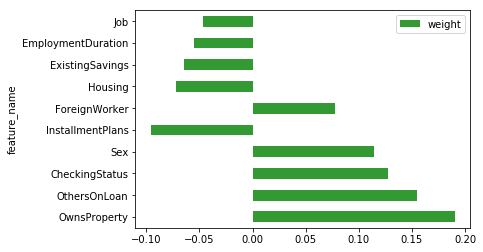

In [69]:
explain_result = pd.DataFrame.from_dict(explain_run['entity']['predictions'][0]['explanation_features'])
explain_result.plot.barh(x='feature_name', y='weight', color='g', alpha=0.8);

# -----------------------**CUARTA SECCIÓN**-----------------------------------------

# 6. Creación de monitores y métricas custom <a name="custom"></a>

## 6.1. Registro de un monitor 

In [70]:
def get_definition(monitor_name):
    monitors_definitions = ai_client.data_mart.monitors.get_details()['monitor_definitions']
    
    for definition in monitors_definitions:
        if monitor_name == definition['entity']['name']:
            return definition
    
    return None

In [71]:
from ibm_ai_openscale.supporting_classes import Metric, Tag

monitor_name = 'my model performance'
metrics = [Metric(name='sensitivity', lower_limit_default=0.8), Metric(name='specificity', lower_limit_default=0.75)]
tags = [Tag(name='region', description='customer geographical region')]

existing_definition = get_definition(monitor_name)

if existing_definition is None:
    my_monitor = ai_client.data_mart.monitors.add(name=monitor_name, metrics=metrics, tags=tags)
else:
    my_monitor = existing_definition

### Listamos monitores

### Obtenemos los detalles de los monitores

In [72]:
monitor_uid = my_monitor['metadata']['guid']

print(monitor_uid)

my_model_performance


In [73]:
my_monitor = ai_client.data_mart.monitors.get_details(monitor_uid=monitor_uid)
print('monitor definition details', my_monitor)

monitor definition details {'entity': {'metrics': [{'expected_direction': 'increasing', 'id': 'sensitivity', 'name': 'sensitivity', 'required': True, 'thresholds': [{'default': 0.8, 'type': 'lower_limit'}]}, {'expected_direction': 'increasing', 'id': 'specificity', 'name': 'specificity', 'required': True, 'thresholds': [{'default': 0.75, 'type': 'lower_limit'}]}], 'name': 'my model performance', 'tags': [{'description': 'customer geographical region', 'id': 'region', 'name': 'region', 'required': True}]}, 'metadata': {'guid': 'my_model_performance', 'url': '/v1/data_marts/27d2155a-b202-44ac-955e-ee20b64f6c89/monitor_definitions/my_model_performance', 'created_at': '2020-01-29T14:56:07.255Z'}}


## 6.2 Habilitamos los monitores custom para la suscripción

In [74]:
from ibm_ai_openscale.supporting_classes import Threshold

thresholds = [Threshold(metric_uid='sensitivity', lower_limit=0.9)]
subscription.monitoring.enable(monitor_uid=monitor_uid, thresholds=thresholds)

### Obtenemos los detalles del monitor

In [75]:
subscription.monitoring.get_details(monitor_uid=monitor_uid)

{'enabled': True,
 'monitor_definition': {'entity': {'metrics': [{'expected_direction': 'increasing',
     'id': 'sensitivity',
     'name': 'sensitivity',
     'required': True,
     'thresholds': [{'default': 0.9, 'type': 'lower_limit'}]},
    {'expected_direction': 'increasing',
     'id': 'specificity',
     'name': 'specificity',
     'required': True}],
   'name': 'my model performance',
   'tags': [{'description': 'customer geographical region',
     'id': 'region',
     'name': 'region',
     'required': True}]},
  'metadata': {'guid': 'my_model_performance',
   'url': '/v1/data_marts/27d2155a-b202-44ac-955e-ee20b64f6c89/monitor_definitions/my_model_performance',
   'created_at': '2020-01-29T14:56:07.255Z'}},
 'thresholds': [{'metric_id': 'sensitivity',
   'type': 'lower_limit',
   'value': 0.9}]}

## 6.3. Almacenamos las métricas custom

In [76]:
metrics = {"specificity": 0.78, "sensitivity": 0.67, "region": "us-south"}

subscription.monitoring.store_metrics(monitor_uid=monitor_uid, metrics=metrics)

[{'asset_id': '4034d109-a06d-4919-8bd2-01658aea8792',
  'binding_id': 'e2cde82b-8a94-4d97-9d46-2288dd99c3af',
  'measurement_id': 'b7622f0c-0bef-49db-bdc1-5f214015aac3',
  'metrics': [{'region': 'us-south',
    'sensitivity': 0.67,
    'specificity': 0.78}],
  'monitor_definition_id': 'my_model_performance',
  'subscription_id': 'cf423917-4e36-499b-be86-86729c7f974f',
  'timestamp': '2020-01-31T13:27:07.430865Z'}]

### Listamos y obtenemos las métricas custom

In [1]:
time.sleep(5)

subscription.monitoring.show_table(monitor_uid=monitor_uid)

NameError: name 'time' is not defined

In [78]:
custom_metrics = subscription.monitoring.get_metrics(monitor_uid=monitor_uid, deployment_uid='credit')
custom_metrics

[{'asset_id': '4034d109-a06d-4919-8bd2-01658aea8792',
  'binding_id': 'e2cde82b-8a94-4d97-9d46-2288dd99c3af',
  'tags': [{'id': 'region', 'value': 'us-south'}],
  'ts': '2020-01-31T13:27:07.430865Z',
  'measurement_id': 'b7622f0c-0bef-49db-bdc1-5f214015aac3',
  'monitor_definition_id': 'my_model_performance',
  'subscription_id': 'cf423917-4e36-499b-be86-86729c7f974f',
  'metrics': [{'lower_limit': 0.9, 'id': 'sensitivity', 'value': 0.67},
   {'id': 'specificity', 'value': 0.78}]}]

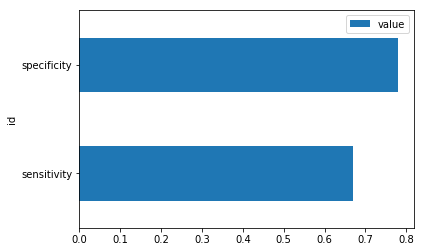

In [79]:
custom_metrics_pandas = subscription.monitoring.get_table_content(monitor_uid=monitor_uid)

%matplotlib inline
custom_metrics_pandas.plot.barh(x='id', y='value');

# Payload analytics <a name="analytics"></a>

## 7.1 Ejecutar cálculo de distribuciones

In [80]:
from datetime import datetime

start_date = "2018-01-01T00:00:00.00Z"
end_date = datetime.utcnow().isoformat() + "Z"

sex_distribution = subscription.payload_logging.data_distribution.run(
            start_date=start_date,
            end_date=end_date,
            group=['prediction', 'Sex'],
            agg=['count'])




 Waiting for end of data distribution run 3c8c38df-2bc1-4203-8955-93391694bdfe 




completed

---------------------------
 Successfully finished run 
---------------------------




## 7.2. Obtener las distribuciones como un pandas dataframe

In [81]:
sex_distribution_run_uid = sex_distribution['id']
distributions_pd = subscription.payload_logging.data_distribution.get_run_result(run_id=sex_distribution_run_uid, format='pandas')
distributions_pd

prediction     Sex  count
0    No Risk  female     64
1    No Risk    male     96
2       Risk  female      6
3       Risk    male     42

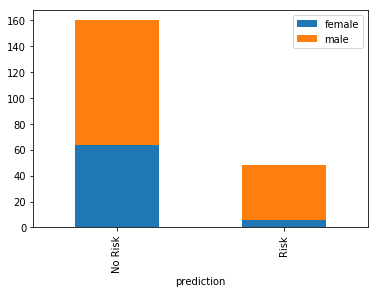

In [82]:
subscription.payload_logging.data_distribution.show_chart(sex_distribution_run_uid);

In [83]:
credit_history_distribution = subscription.payload_logging.data_distribution.run(
            start_date=start_date,
            end_date=end_date,
            group=['prediction', 'CreditHistory'],
            agg=['count'])




 Waiting for end of data distribution run db1fc058-4512-4c17-8827-c958101790ab 




completed

---------------------------
 Successfully finished run 
---------------------------




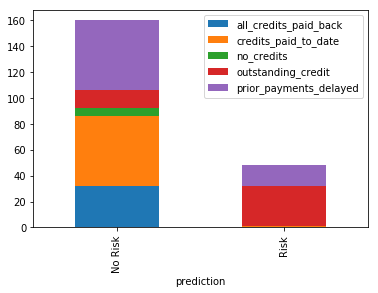

In [84]:
credit_history_distribution_run_uid = credit_history_distribution['id']

subscription.payload_logging.data_distribution.show_chart(credit_history_distribution_run_uid);

# 8. Business Application <a name="application"></a>

In [85]:
from ibm_ai_openscale.supporting_classes import BusinessMetric, AggregationMethods

En las celdas siguientes, los "business payload fields" y las "business metrics" se describen para su aplicación. `business payload fields` es una lista de columnas de carga útil empresarial cargadas al final de la sección" Datos históricos ". `business metrics` define métricas (BKPI) que se calcularán en la aplicación creada. La aplicación se ejecuta en [sección] (# run_application) después de cargar datos históricos.

In [86]:
business_payload_fields = [
                {
                    "name": "LoanDuration",
                    "type": "number",
                    "description": "Duration of the loan"
                },
                {
                    "name": "LoanPurpose",
                    "type": "string",
                    "description": "Purpose of the loan"
                },
                {
                    "name": "LoanAmount",
                    "type": "number",
                    "description": "Amount of the loan"
                },
                {
                    "name": "InstallmentPercent",
                    "type": "number",
                    "description": "Installment percents"
                },
                {
                    "name": "AcceptedPercent",
                    "type": "number"
                },
                {
                    "name": "AmountGranted",
                    "type": "number",
                    "description": "Risk percent"
                },
                {
                    "name": "Accepted",
                    "type": "number",
                    "description": "Number of loans accepted"
                }
            ]

In [87]:
business_metrics = [BusinessMetric(metric_name='Accepted Credits', description="Accepted Credits Daily",
                                           field_name='Accepted', aggregation=AggregationMethods.SUM,
                                   time_unit='day', time_count=1, lower_limit=2150),
                    BusinessMetric(metric_name='Credit Amount Granted', description="Credit Amount Granted Daily",
                                   field_name='AmountGranted', aggregation=AggregationMethods.SUM,
                                   time_unit='day', time_count=1, lower_limit=5500000)]

## 8.1 Añadir las aplicaciones de negocio

In [89]:
application_details = ai_client.data_mart.applications.add(name="Tutorial Credit Risk Application",
                                                           description="Tutorial Business Application",
                                                           subscription_ids=[subscription.uid],
                                                           business_metrics=business_metrics,
                                                           payload_schema=business_payload_fields)
application_id = application_details['metadata']['id']

In [90]:
while application_details['entity']['status']['state'] == 'preparing':
    print(datetime.utcnow().strftime('%H:%M:%S'), application_details['entity']['status']['state'] )
    time.sleep(10)
    application_details = ai_client.data_mart.applications.get_details(application_id)
print("Final application status: {}".format(application_details['entity']['status']['state']) )

13:27:24 preparing
Final application status: active


# 9. Datos históricos<a name="historical"></a>

In [94]:
historyDays = 7

 ## 9.1. Insertamos datos históricos

La siguiente sección del notebook descarga y escribe datos históricos en las tablas de carga y medición para simular un modelo de producción que ha sido monitoreado y que recibe tráfico regular durante los últimos siete días. Estos datos históricos se pueden ver en la interfaz de usuario de Watson OpenScale. El código usa las API Python y REST para escribir estos datos.

In [95]:
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/scikit-learn/history_payloads_with_transaction_id_scikit_0.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/scikit-learn/history_payloads_with_transaction_id_scikit_1.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/scikit-learn/history_payloads_with_transaction_id_scikit_2.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/scikit-learn/history_payloads_with_transaction_id_scikit_3.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/scikit-learn/history_payloads_with_transaction_id_scikit_4.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/scikit-learn/history_payloads_with_transaction_id_scikit_5.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/scikit-learn/history_payloads_with_transaction_id_scikit_6.json

!ls -lh history_payloads_with_transaction_id_scikit_*.json

-rw-r----- 1 dsxuser dsxuser 2.2M Jan 31 09:13 history_payloads_with_transaction_id_scikit_0.json
-rw-r----- 1 dsxuser dsxuser 2.2M Jan 31 09:13 history_payloads_with_transaction_id_scikit_1.json
-rw-r----- 1 dsxuser dsxuser 2.2M Jan 31 09:13 history_payloads_with_transaction_id_scikit_2.json
-rw-r----- 1 dsxuser dsxuser 2.3M Jan 31 09:13 history_payloads_with_transaction_id_scikit_3.json
-rw-r----- 1 dsxuser dsxuser 2.2M Jan 31 09:13 history_payloads_with_transaction_id_scikit_4.json
-rw-r----- 1 dsxuser dsxuser 2.2M Jan 31 09:13 history_payloads_with_transaction_id_scikit_5.json
-rw-r----- 1 dsxuser dsxuser 2.2M Jan 31 09:13 history_payloads_with_transaction_id_scikit_6.json


In [96]:
from ibm_ai_openscale.utils.inject_demo_data import DemoData
import os

historicalData = DemoData(aios_credentials=WOS_CREDENTIALS)
historical_data_path=os.getcwd()

historicalData.load_historical_scoring_payload(subscription, deployment_uid,file_path=historical_data_path, day_template="history_payloads_with_transaction_id_scikit_{}.json" )

Loading historical scoring payload...
Day 0 injection.
Daily loading finished.
Day 1 injection.
Daily loading finished.
Day 2 injection.
Daily loading finished.
Day 3 injection.
Daily loading finished.
Day 4 injection.
Daily loading finished.
Day 5 injection.
Daily loading finished.
Day 6 injection.
Daily loading finished.


In [97]:
data_mart_id = subscription.get_details()['metadata']['url'].split('/service_bindings')[0].split('marts/')[1]
print(data_mart_id)

27d2155a-b202-44ac-955e-ee20b64f6c89


In [98]:
performance_metrics_url = WOS_CREDENTIALS['url'] + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/metrics'
print(performance_metrics_url)

https://api.aiopenscale.cloud.ibm.com/v1/data_marts/27d2155a-b202-44ac-955e-ee20b64f6c89/metrics


## Insertamos datos históricos de fairness

In [99]:
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_fairness.json
!ls -lh history_fairness.json

-rw-r----- 1 dsxuser dsxuser 1.4M Jan 31 09:15 history_fairness.json


In [100]:
import datetime

with open('history_fairness.json', 'r') as history_file:
    payloads = json.load(history_file)

for day in range(historyDays):
    print('Loading day', day + 1)
    metrics = []
    
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        index = (day * 24 + hour) % len(payloads) # wrap around and reuse values if needed
        
        metric = {
            'metric_type': 'fairness',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': payloads[index]
        }
        metrics.append(metric)
    response = requests.post(performance_metrics_url, json=metrics, headers=ai_client._get_headers())
print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Insertamos métricas históricas de mitigación de sesgos

In [101]:
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_debias.json -O history_debias.json
!ls -lh history_debias.json

-rw-r----- 1 dsxuser dsxuser 553K Jan 31 13:28 history_debias.json


In [102]:
with open('history_debias.json', 'r') as history_file:
    payloads = json.load(history_file)

for day in range(historyDays):
    print('Loading day', day + 1)
    debias_metrics = []
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        index = (day * 24 + hour) % len(payloads) # wrap around and reuse values if needed

        debiasMetric = {
            'metric_type': 'debiased_fairness',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': payloads[index]
        }

        debias_metrics.append(debiasMetric)
    response = requests.post(performance_metrics_url, json=debias_metrics, headers=ai_client._get_headers())
print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Insertamos métricas históricas de calidad

In [103]:
measurements = [0.76, 0.78, 0.68, 0.72, 0.73, 0.77, 0.80]
for day in range(historyDays):
    quality_metrics = []
    print('Day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        qualityMetric = {
            'metric_type': 'quality',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': {
                'quality': measurements[day],
                'threshold': 0.7,
                'metrics': [
                    {
                        'name': 'auroc',
                        'value': measurements[day],
                        'threshold': 0.7
                    }
                ]
            }
        }
        
        quality_metrics.append(qualityMetric)
    
    response = requests.post(performance_metrics_url, json=quality_metrics, headers=ai_client._get_headers())

print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insertamos matrices de confusión históricas

In [104]:
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_quality_metrics.json -O history_quality_metrics.json
!ls -lh history_quality_metrics.json

-rw-r----- 1 dsxuser dsxuser 79K Jan 31 13:28 history_quality_metrics.json


In [105]:
measurements_url = WOS_CREDENTIALS['url'] + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/measurements'
print(measurements_url)

https://api.aiopenscale.cloud.ibm.com/v1/data_marts/27d2155a-b202-44ac-955e-ee20b64f6c89/measurements


In [106]:
with open('history_quality_metrics.json') as json_file:
    records = json.load(json_file)
    
for day in range(historyDays):
    index = 0
    measurments = []
    print('Day', day + 1)
    
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')

        measurement = {
            "monitor_definition_id": 'quality',
            "binding_id": subscription.binding_uid,
            "subscription_id": subscription.uid,
            "asset_id": subscription.source_uid,
            'metrics': [records[index]['metrics']],
            'sources': [records[index]['sources']],
            'timestamp': score_time
        }

        measurments.append(measurement)
        index+=1

    response = requests.post(measurements_url, json=measurments, headers=ai_client._get_headers())

print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insertamos medidas de rendimiento históricas

In [107]:
for day in range(historyDays):
    performance_metrics = []
    print('Day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        score_count = random.randint(60, 600)
        score_resp = random.uniform(60, 300)

        performanceMetric = {
            'metric_type': 'performance',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': {
                'response_time': score_resp,
                'records': score_count
            }
        }
        performance_metrics.append(performanceMetric)

    response = requests.post(performance_metrics_url, json=performance_metrics, headers=ai_client._get_headers())

print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insertamos etiquetas manuales históricas

In [108]:
manual_labeling_url = WOS_CREDENTIALS['url'] + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/manual_labelings'
print(manual_labeling_url)

https://api.aiopenscale.cloud.ibm.com/v1/data_marts/27d2155a-b202-44ac-955e-ee20b64f6c89/manual_labelings


In [109]:
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_manual_labeling.json -O history_manual_labeling.json
!ls -lh history_manual_labeling.json

-rw-r----- 1 dsxuser dsxuser 926K Jan 31 13:28 history_manual_labeling.json


In [110]:
with open('history_manual_labeling.json', 'r') as history_file:
    records = json.load(history_file)

for day in range(historyDays):
    print('Loading day', day + 1)
    record_json = []
    for hour in range(24):
        for record in records:
            if record['fastpath_history_day'] == day and record['fastpath_history_hour'] == hour:
                record['binding_id'] = binding_uid
                record['subscription_id'] = model_uid
                record['asset_revision'] = model_uid
                record['deployment_id'] = deployment_uid
                record['scoring_timestamp'] = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
                record_json.append(record)
    response = requests.post(manual_labeling_url, json=record_json, headers=ai_client._get_headers())

print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Insertamos medidas de drift históricas

In [111]:
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_drift_measurement_0.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_drift_measurement_1.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_drift_measurement_2.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_drift_measurement_3.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_drift_measurement_4.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_drift_measurement_5.json
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_drift_measurement_6.json
!ls -lh history_drift_measurement_*.json

-rw-r----- 1 dsxuser dsxuser 832K Jan 31 09:18 history_drift_measurement_0.json
-rw-r----- 1 dsxuser dsxuser 868K Jan 31 09:18 history_drift_measurement_1.json
-rw-r----- 1 dsxuser dsxuser 870K Jan 31 09:18 history_drift_measurement_2.json
-rw-r----- 1 dsxuser dsxuser 910K Jan 31 09:18 history_drift_measurement_3.json
-rw-r----- 1 dsxuser dsxuser 841K Jan 31 09:18 history_drift_measurement_4.json
-rw-r----- 1 dsxuser dsxuser 836K Jan 31 09:18 history_drift_measurement_5.json
-rw-r----- 1 dsxuser dsxuser 840K Jan 31 09:18 history_drift_measurement_6.json


In [112]:
print(measurements_url)

https://api.aiopenscale.cloud.ibm.com/v1/data_marts/27d2155a-b202-44ac-955e-ee20b64f6c89/measurements


In [113]:
for day in range(historyDays):
    measurements = []

    with open("history_drift_measurement_{}.json".format(day), 'r') as history_file:
        drift_daily_measurements = json.load(history_file)
    print('Loading day', day + 1)

    #Historical data contains 8 records per day - each represents 3 hour drift window.
    
    for nb_window, records in enumerate(drift_daily_measurements):
        for record in records:
            window_start =  (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24 * day + (nb_window+1)*3 + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ') # first_payload_record_timestamp_in_window (oldest)
            window_end = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24 * day + nb_window*3 + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')# last_payload_record_timestamp_in_window (most recent)
            #modify start and end time for each record
            record['sources'][0]['data']['start'] = window_start
            record['sources'][0]['data']['end'] = window_end
            
            measurement = {
                "monitor_definition_id": "drift",
                "binding_id": subscription.binding_uid,
                "subscription_id": subscription.uid,
                "asset_id": subscription.source_uid,
                'metrics': record['metrics'],
                'sources': record['sources'],
                'timestamp': window_start,
                'process': 'Drift run for subscription_{}'.format(subscription.uid)
            }

            measurements.append(measurement)
    response = requests.post(measurements_url, json=measurements, headers=ai_client._get_headers())
    print("Daily loading finished.")

Loading day 1
Daily loading finished.
Loading day 2
Daily loading finished.
Loading day 3
Daily loading finished.
Loading day 4
Daily loading finished.
Loading day 5
Daily loading finished.
Loading day 6
Daily loading finished.
Loading day 7
Daily loading finished.


## Insertamos payload de negocio

Following section triggers two minute waiting for all historical records to be loaded succesfully.


In [114]:
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_business_payloads_week.csv -O history_business_payloads_week.csv
!ls -lh history_business_payloads_week.csv

-rw-r----- 1 dsxuser dsxuser 1.6M Jan 31 13:28 history_business_payloads_week.csv


In [115]:
business_payload_data_set_id = application_details['entity']['business_payload_data_set_id']

historicalData.load_historical_business_payload(business_payload_data_set_id, file_path=historical_data_path, file_name="history_business_payloads_week.csv")
time.sleep(120)

**Note:** Now in business payload table should be total 20160 records.

In [116]:
print('Number of records in business payload table: ', ai_client.data_mart.applications.get_business_payload_records_count(application_id))

Number of records in business payload table:  20160


# 10. Ejecutamos la aplicación de negocio  <a id="run_application"></a>

In [117]:
run_details = ai_client.data_mart.applications.run(application_id)

## Datos adicionales que nos van a ayudar a depurar

In [118]:
print('Datamart:', data_mart_id)
print('Model:', model_uid)
print('Deployment:', deployment_uid)
print('Binding:', binding_uid)
print('Scoring URL:', credit_risk_scoring_endpoint)

Datamart: 27d2155a-b202-44ac-955e-ee20b64f6c89
Model: 4034d109-a06d-4919-8bd2-01658aea8792
Deployment: 9c73141e-6197-4e29-ac94-794554f76477
Binding: e2cde82b-8a94-4d97-9d46-2288dd99c3af
Scoring URL: https://us-south.ml.cloud.ibm.com/v3/wml_instances/e2cde82b-8a94-4d97-9d46-2288dd99c3af/deployments/9c73141e-6197-4e29-ac94-794554f76477/online


## Identificamos transacciones para explicar

Los ID de transacción identificados por las celdas a continuación se pueden copiar y pegar en la pestaña Explicabilidad del panel de control de OpenScale.

In [119]:
payload_data = subscription.payload_logging.get_table_content(limit=60)
payload_data.filter(items=['scoring_id', 'predictedLabel', 'probability'])

scoring_id  \
0   495ec5f1b673c2275a982b06ac43b23c-200   
1   495ec5f1b673c2275a982b06ac43b23c-199   
2   495ec5f1b673c2275a982b06ac43b23c-198   
3   495ec5f1b673c2275a982b06ac43b23c-197   
4   495ec5f1b673c2275a982b06ac43b23c-196   
5   495ec5f1b673c2275a982b06ac43b23c-195   
6   495ec5f1b673c2275a982b06ac43b23c-194   
7   495ec5f1b673c2275a982b06ac43b23c-193   
8   495ec5f1b673c2275a982b06ac43b23c-192   
9   495ec5f1b673c2275a982b06ac43b23c-191   
10  495ec5f1b673c2275a982b06ac43b23c-190   
11  495ec5f1b673c2275a982b06ac43b23c-189   
12  495ec5f1b673c2275a982b06ac43b23c-188   
13  495ec5f1b673c2275a982b06ac43b23c-187   
14  495ec5f1b673c2275a982b06ac43b23c-186   
15  495ec5f1b673c2275a982b06ac43b23c-185   
16  495ec5f1b673c2275a982b06ac43b23c-184   
17  495ec5f1b673c2275a982b06ac43b23c-183   
18  495ec5f1b673c2275a982b06ac43b23c-182   
19  495ec5f1b673c2275a982b06ac43b23c-181   
20  495ec5f1b673c2275a982b06ac43b23c-180   
21  495ec5f1b673c2275a982b06ac43b23c-179   
22  495ec5f1b673c2275a982b06ac43b23c-178   
23  495ec5f1b673c2275a982b06ac43b23c-177   
24  495ec5f1b673c2275a982b06ac43b23c-176   
25  495ec5f1b673c2275a982b06ac43b23c-175   
26  495ec5f1b673c2275a982b06ac43b23c-174   
27  495ec5f1b673c2275a982b06ac43b23c-173   
28  495ec5f1b673c2275a982b06ac43b23c-172   
29  495ec5f1b673c2275a982b06ac43b23c-171   
30  495ec5f1b673c2275a982b06ac43b23c-170   
31  495ec5f1b673c2275a982b06ac43b23c-169   
32  495ec5f1b673c2275a982b06ac43b23c-168   
33  495ec5f1b673c2275a982b06ac43b23c-167   
34  495ec5f1b673c2275a982b06ac43b23c-166   
35  495ec5f1b673c2275a982b06ac43b23c-165   
36  495ec5f1b673c2275a982b06ac43b23c-164   
37  495ec5f1b673c2275a982b06ac43b23c-163   
38  495ec5f1b673c2275a982b06ac43b23c-162   
39  495ec5f1b673c2275a982b06ac43b23c-161   
40  495ec5f1b673c2275a982b06ac43b23c-160   
41  495ec5f1b673c2275a982b06ac43b23c-159   
42  495ec5f1b673c2275a982b06ac43b23c-158   
43  495ec5f1b673c2275a982b06ac43b23c-157   
44  495ec5f1b673c2275a982b06ac43b23c-156   
45  495ec5f1b673c2275a982b06ac43b23c-155   
46  495ec5f1b673c2275a982b06ac43b23c-154   
47  495ec5f1b673c2275a982b06ac43b23c-153   
48  495ec5f1b673c2275a982b06ac43b23c-152   
49  495ec5f1b673c2275a982b06ac43b23c-151   
50  495ec5f1b673c2275a982b06ac43b23c-150   
51  495ec5f1b673c2275a982b06ac43b23c-149   
52  495ec5f1b673c2275a982b06ac43b23c-148   
53  495ec5f1b673c2275a982b06ac43b23c-147   
54  495ec5f1b673c2275a982b06ac43b23c-146   
55  495ec5f1b673c2275a982b06ac43b23c-145   
56  495ec5f1b673c2275a982b06ac43b23c-144   
57  495ec5f1b673c2275a982b06ac43b23c-143   
58  495ec5f1b673c2275a982b06ac43b23c-142   
59  495ec5f1b673c2275a982b06ac43b23c-141   

                                   probability  
0    [0.9252284604459459, 0.07477153955405412]  
1    [0.04690428723470963, 0.9530957127652904]  
2    [0.9382416521770496, 0.06175834782295037]  
3     [0.6569122352669601, 0.3430877647330399]  
4     [0.42367586199114105, 0.576324138008859]  
5   [0.9737817478738762, 0.026218252126123855]  
6     [0.9450355723930663, 0.0549644276069337]  
7     [0.8350518934422186, 0.1649481065577814]  
8     [0.4803977743649086, 0.5196022256350914]  
9    [0.8250617516656895, 0.17493824833431051]  
10   [0.9658679503125731, 0.03413204968742689]  
11   [0.8284417523614516, 0.17155824763854843]  
12    [0.7440487127029286, 0.2559512872970714]  
13    [0.6557838738176118, 0.3442161261823881]  
14   [0.9651559960083268, 0.03484400399167325]  
15   [0.9083270616548104, 0.09167293834518964]  
16   [0.7404630522730107, 0.25953694772698926]  
17    [0.7682829167076632, 0.2317170832923367]  
18   [0.04453287548585794, 0.9554671245141421]  
19   [0.36057843004497114, 0.6394215699550289]  
20  [0.9819416150787448, 0.018058384921255256]  
21   [0.8206343092878898, 0.17936569071211014]  
22   [0.7940267937799835, 0.20597320622001647]  
23     [0.716060185062007, 0.2839398149379931]  
24      [0.585971630564876, 0.414028369435124]  
25   [0.6564393502832208, 0.34356064971677924]  
26      [0.58241309624

## ¡Enhorabuena!

Has terminado los laboratorios de IBM Watson OpenScale. Ahora puedes verlo en el [OpenScale Dashboard](https://aiopenscale.cloud.ibm.com/). 

